In [1]:
%matplotlib inline
import os, sys
import time
import pyvisa
import warnings
import numpy as np
import qcodes as qc
import matplotlib.pyplot as plt

def find_qcodes_local_dir():
    dirpath = os.getcwd()
    while True:
        dirpath, folder_name = os.path.split(dirpath)
        if folder_name == 'QCoDeS_local':
            return os.path.join(dirpath, folder_name)
        if not folder_name:  # Reached the root directory
            return None
qcodes_local_dir = find_qcodes_local_dir()
sys.path.append(f'{qcodes_local_dir}')

from tqdm import tqdm
from pprint import pprint
from time import sleep, monotonic, time
from IPython.display import clear_output, display, HTML
from qcodes.dataset.measurements import Measurement
from qcodes.utils.metadata import diff_param_values
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes import Parameter, ManualParameter, ScaledParameter
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes import ManualParameter, ScaledParameter
from sweeps_v2 import do1d, do2d, time_sweep, measure_until, do1d_until

from Test.Analysis_functions_v3 import *

print('Imported all modules, QCoDeS version:', qc.__version__, 'initialized')

Imported all modules, QCoDeS version: 0.38.1 initialized


In [2]:
def get_qcodes_local_path(PC_name = "116-1"):
    """
    根據選擇的代號獲取對應的路徑。

    參數:
    PC_name (str): 電腦的代號, P6F-1, P6f-2, 116-1, 116-2, Albert-Mac

    返回:
    str: 對應的路徑，如果代號不存在則返回 None

    """
    # 定義代號到路徑的映射
    qcodes_local_dir_dict = {
        "116-1": "C:\\Users\\admin\\Documents\\GitHub\\QCoDeS_local",
        "116-2": "C:\\Users\\quant\\OneDrive\\Documents\\GitHub\\QCoDeS_local",
        "P6F-1": "C:\\Users\\admin\\Documents\\GitHub\\QCoDeS_local",
        "P6f-2": "C:\\Users\\Ke Lab\\Documents\\GitHub\\QCoDeS_local",
        "Albert-Mac": "/Users/albert-mac/Code/GitHub/QCoDeS_local"
    }

    # 報錯: 未找到對應的路徑
    if PC_name not in qcodes_local_dir_dict:
        raise ValueError(f"未找到代號 {PC_name} 對應的路徑, 請輸入以下代號之一: {', '.join(qcodes_local_dir_dict.keys())}")
    
    # 根據代號獲取對應的路徑
    return qcodes_local_dir_dict.get(PC_name)

def find_init_file(file_name, PC_name="116-1"):
    qcodes_local_path = get_qcodes_local_path(PC_name)
    if qcodes_local_path:
        for root, dirs, files in os.walk(qcodes_local_path):
            if file_name in files:
                return os.path.join(root, file_name)
    return None


def path_display(paths):
    for name, file_path in paths.items():
        if file_path:
            display(HTML(f'{name}:<br><a href="file://{file_path}" target="_blank">{file_path}</a>'))
        else:
            print(f"{name}: {file_path} not found")

# 使用字典來存放變數名及其值
paths = {
    'qcodes_local_path': get_qcodes_local_path("116-1"),
    'init_database_py_path': find_init_file('init_database_v2.py'),
    'init_fridge_py_path': find_init_file('init_fridge_v2.py'),
    'init_BF1_path': find_init_file('init_BF1_v2.py')
}

# 調用 path_display 函數
path_display(paths)

In [3]:
fridge_name = 'BF1'
%run {paths["init_fridge_py_path"]} {fridge_name}

Found init_BF1_v2.py at: c:\Users\admin\Documents\GitHub\QCoDeS_local\fridge_specific\init_BF1_v2.py
Device: TCPIP0::K-E5080B-02870::inst0::INSTR
IDN: Keysight Technologies,E5080B,MY59202870,A.15.10.08

Error connecting to ASRL1::INSTR: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.
Device: GPIB0::5::INSTR
IDN: Stanford_Research_Systems,SR860,004608,V1.51

Connected to: Stanford_Research_Systems SR860 (serial:004608, firmware:V1.51) in 0.05s
Added SR860_1 at GPIB0::5::INSTR to the station.
Device: GPIB0::7::INSTR
IDN: KEITHLEY INSTRUMENTS,MODEL DMM6500,04518181,1.7.7b

Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04518181, firmware:1.7.7b) in 0.02s
Added Keithley DMM6500 at GPIB0::7::INSTR to the station.
Connected to: AMERICAN MAGNETICS INC. 430 (serial:430-22-114, firmware:3.15) in 2.36s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:430-22-113, firmware:3.15) in 1.30s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:430-22-111, firmware:3.15) in 1.

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\qcodes\instrument\instrument_base.py:543: UserWarning: Changed AMI430-3D to AMI430_3D for instrument identifier
  warnings.warn(f"Changed {name} to {new_name} for instrument identifier")


Added z to the station.
Added y to the station.
Added x to the station.
Added AMI430_3D to the station.

Station list:
{'AMI430_3D': <AMI430_3D: AMI430_3D>,
 'DMM6500': <Keithley_6500: DMM6500>,
 'SR860': <SR860: SR860>,
 'x': <AMI430: x>,
 'y': <AMI430: y>,
 'z': <AMI430: z>}


In [4]:
reuse = True
%run {paths["init_database_py_path"]} {reuse}

Using existing database file:
c:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\024-1Shankar\024-1Shankar_2024-08-29_01.db


In [5]:
Irange = Parameter('Irange', label='current range', unit='', set_cmd=None, get_cmd=None)
Vrange = Parameter('Vrange', label='voltage range', unit='', set_cmd=None, get_cmd=None)
TGrange = Parameter('TGrange', label='Top gate range', unit='', set_cmd=None, get_cmd=None)

#division paraemtrs required for simplier update: they used as an argument for scaled paraemtrs of sorce instruments

Irange_division = Parameter('Irange_division', 
                            label='scaled current range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1 / Irange())

Vrange_division = Parameter('Vrange_division', 
                            label='scaled voltage range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1 / Vrange())

TGrange_division = Parameter('TGrange_division', 
                             label='scaled Top gate range', unit='', 
                             set_cmd=None, get_cmd=lambda : 1 / TGrange())

Irange_AC_division = Parameter('Irange_AC_division', 
                               label='scaled current range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 1 / Irange())

Vrange_AC_division = Parameter('Vrange_AC_division', 
                               label='scaled voltage range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 1 / Vrange())

Gain_K1 = Parameter('Gain_K1', label='Gain K1', unit='', set_cmd=None, get_cmd=None)
Gain_K2 = Parameter('Gain_K2', label='Gain K2', unit='', set_cmd=None, get_cmd=None)
Gain_L1 = Parameter('Gain_L1', label='Gain L1', unit='', set_cmd=None, get_cmd=None)
Gain_L2 = Parameter('Gain_L2', label='Gain L2', unit='', set_cmd=None, get_cmd=None)

#Add components
station.add_component(Irange)
station.add_component(Vrange)
station.add_component(TGrange)

station.add_component(Irange_division)
station.add_component(Vrange_division)
station.add_component(TGrange_division)

station.add_component(Irange_AC_division)
station.add_component(Vrange_AC_division)
                             
station.add_component(Gain_K1)
station.add_component(Gain_K2)
station.add_component(Gain_L1)
station.add_component(Gain_L2)

'Gain_L2'

In [6]:
Irange.set(1e-6) #Unit Amp V=IR, 1V= 1e-6 x 1MOhm=1e-7 x 10MOhm
Vrange.set(10) ## need to be sync with K213 range #Unit Volt
TGrange.set(1) #Unit Volt
Gain_K1.set(100)
Gain_K2.set(100)
# Gain_K3.set(1e2)
Gain_L1.set(Gain_K1())
Gain_L2.set(Gain_K2())
#division parameters are updated automatically

In [9]:

SR860_1.sine_outdc()

0.10000000149

In [10]:
appl_current = ScaledParameter(SR860_1.sine_outdc, division = Irange_division, name = 'appl_current', unit = 'A')
meas_voltage_K2 = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_voltage_K2', unit = 'V')
meas_current_K2 = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_current_K2', unit = 'A')
meas_leakage = ScaledParameter(DMM6500.amplitude, division = Gain_K2, name = 'meas_leakage', unit = 'A')
station.add_component(appl_current)
station.add_component(meas_voltage_K2)
station.add_component(meas_current_K2)
station.add_component(meas_leakage)

'meas_leakage'

In [12]:
appl_current_AC = ScaledParameter(SR860_1.amplitude, division = Irange_AC_division, name = 'appl_current_AC', unit = 'A')
appl_voltage_AC = ScaledParameter(SR860_1.amplitude, division = Vrange_AC_division, name = 'appl_voltage_AC', unit = 'V')
meas_voltage_AC_L1 = ScaledParameter(SR860_1.X, division = Gain_L1, name = 'meas_voltage_SR860_1', unit = 'V')
meas_current_AC_L1 = ScaledParameter(SR860_1.X, division = Gain_L1, name = 'meas_current_SR860_1', unit = 'A')
meas_phase_AC_L1 = ScaledParameter(SR860_1.P, division = 1, name = 'meas_phase_SR860_1', unit = 'degree')
meas_voltage_AC_L1_R = ScaledParameter(SR860_1.R, division = Gain_L1, name = 'meas_voltage_R_SR860_1', unit = 'V')
meas_voltage_AC_L1_P = ScaledParameter(SR860_1.P, division = 1, name = 'meas_voltage_SR860_1_P', unit = 'degree')
meas_current_AC_L1_P = ScaledParameter(SR860_1.P, division = 1, name = 'meas_current_SR860_1_P', unit = 'degree')
station.add_component(appl_current_AC)
station.add_component(appl_voltage_AC)
station.add_component(meas_voltage_AC_L1)
station.add_component(meas_current_AC_L1)
station.add_component(meas_phase_AC_L1)
station.add_component(meas_voltage_AC_L1_R)

'meas_voltage_R_SR860_1'

In [17]:
def get_R_from_IV(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
    current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

def get_R_from_IV_2(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
    current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

In [20]:
K2440.rangev()
# K2440.output(1)
# K2440.volt()


2.1

In [18]:
appl_current(4e-6)  

In [33]:
DMM6500.averaging_enabled(False)

In [29]:
DMM6500.averaging_count(5)

In [18]:
magnet_x.field(60e-3)
magnet_x.field()

0.059999388

In [41]:
magnet_x.field(0)
magnet_x.field()

-7.5342e-05

In [38]:
# magnet_y.field(1e-3)
magnet_y.field()

-7.3e-08

There is (are) already experiment(s) with the name of I-V and sample name of 1KOhm in the database.


Starting experimental run with id: 45. 


100%|██████████| 101/101 [00:24<00:00,  4.04it/s]
Trying to mark a run completed that was already completed.


Ic = -0.059999999999999984 µA
 Ir = 0.07799999999999999 µA
 R_fit = 1006.8919544415635 Ω
 IcRn = -60.41351726649379 µV
 R_fit0 = 1003.3119545454567 Ω
 R_fit1 = 1010.4719543376704 Ω



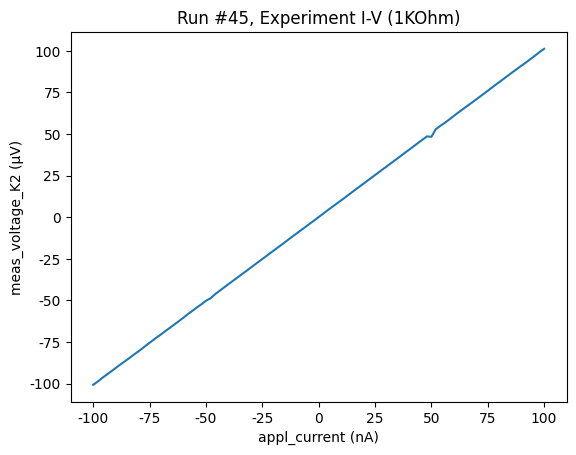

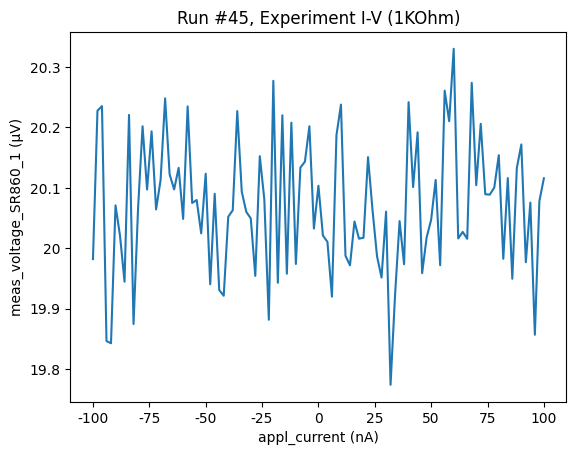

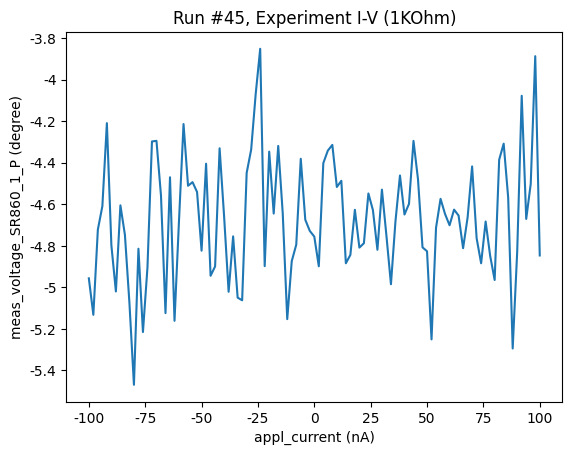

In [37]:
I_range=0.1e-6
wait_time = 200e-3
Bx = round(magnet_x.field() * 1e3, 2)
By = round(magnet_y.field() * 1e3, 2)

appl_current(-I_range)
exp = qc.new_experiment('I-V', sample_name=f'1KOhm')
# exp = qc.new_experiment('I-V', sample_name=f'024-1_33-32-10-11_{Bx=}_{By=}mT{wait_time=}s')
dataid = do1d(appl_current, -I_range ,I_range, 101, wait_time, meas_voltage_K2, meas_voltage_AC_L1, meas_voltage_AC_L1_P)
appl_current(0)

plot_by_id(dataid)
get_R_from_IV(dataid)
plot_IV_and_dVdI(dataid)


Starting experimental run with id: 25. 


first parameter: 100%|██████████| 201/201 [53:06<00:00, 15.85s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #25, Experiment IV-Bx\n(020-1_21-20-30-31_-Bx_By=-0.0mT_wait_time=0.03s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x218898ea820>])

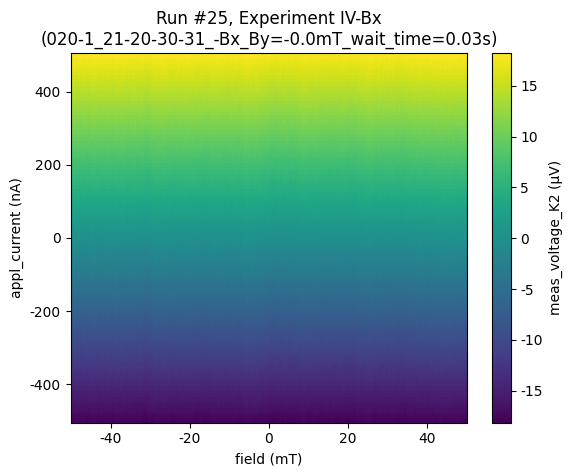

In [38]:
I_range=0.5e-6
wait_time = 30e-3
Bx = round(magnet_x.field() * 1e3, 2)
By = round(magnet_y.field() * 1e3, 2)

K2440.output(1)
appl_current(-I_range)
# direction = '-' if By > 0 else '+'

exp = qc.new_experiment('IV-Bx', sample_name=f'020-1_21-20-30-31_-Bx_{By=}mT_{wait_time=}s')

dataid = do2d(magnet_x.field, 50e-3, -50e-3, 201 , 0.5, appl_current, -I_range ,I_range, 101, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)


plot_by_id(dataid)

In [94]:
magnet_y.field(0.055)

In [100]:
magnet_y.field()

-4.37e-07

There is (are) already experiment(s) with the name of IV-By and sample name of 020-1_21-20-30-31_+By_Bx=0.0mT_wait_time=0.03s in the database.


Starting experimental run with id: 25. 


first parameter: 100%|██████████| 251/251 [37:53<00:00,  9.06s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #25, Experiment IV-By\n(020-1_21-20-30-31_+By_Bx=0.0mT_wait_time=0.03s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x1f577ac3520>])

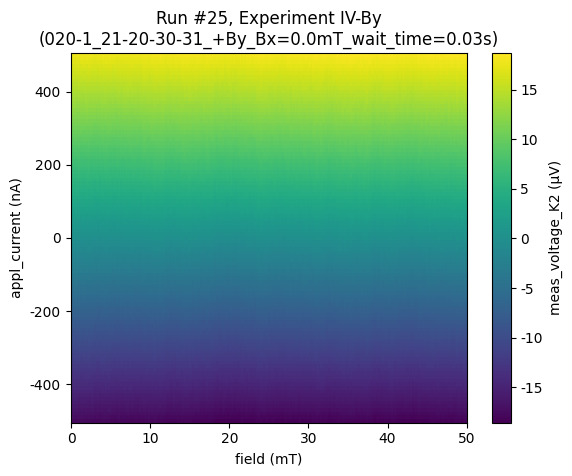

In [91]:
I_range=0.5e-6
wait_time = 30e-3
Bx = round(magnet_x.field() * 1e3, 2)
By = round(magnet_y.field() * 1e3, 2)

K2440.output(1)
appl_current(-I_range)
# direction = '-' if By > 0 else '+'

exp = qc.new_experiment('IV-By', sample_name=f'020-1_21-20-30-31_By_{Bx=}mT_{wait_time=}s')

dataid = do2d(magnet_y.field, 50e-3, -50e-3, 251 , 0.5, appl_current, -I_range ,I_range, 101, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

Starting experimental run with id: 15. 


first parameter: 100%|██████████| 101/101 [13:42<00:00,  8.14s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #15, Experiment IV-By\n(020-1_21-20-30-31_-By_Bx=-0.0mT_wait_time=0.03s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x1f575546850>])

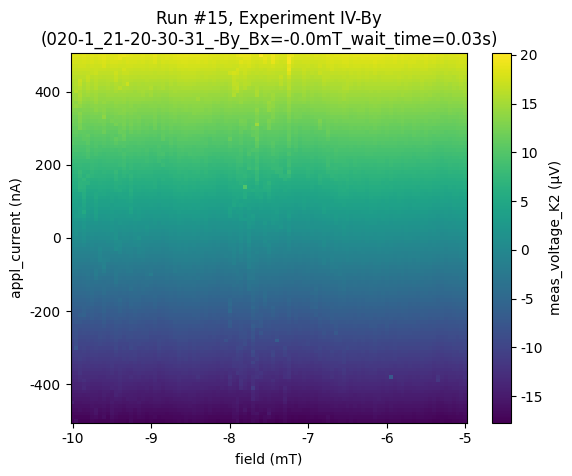

In [66]:
I_range=0.5e-6
wait_time = 30e-3
Bx = round(magnet_x.field() * 1e3, 2)
By = round(magnet_y.field() * 1e3, 2)

K2440.output(1)
appl_current(-I_range)
# direction = '-' if By > 0 else '+'

exp = qc.new_experiment('IV-By', sample_name=f'020-1_21-20-30-31_-By_{Bx=}mT_{wait_time=}s')

dataid = do2d(magnet_y.field, -5e-3, -10e-3, 101 , 0.5, appl_current, -I_range ,I_range, 101, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

There is (are) already experiment(s) with the name of IV-By and sample name of 020-1_21-20-30-31_-By_Bx=-0.0mT_wait_time=0.03s in the database.


Starting experimental run with id: 16. 


first parameter: 100%|██████████| 101/101 [13:40<00:00,  8.13s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #16, Experiment IV-By\n(020-1_21-20-30-31_-By_Bx=-0.0mT_wait_time=0.03s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x1f575b5b340>])

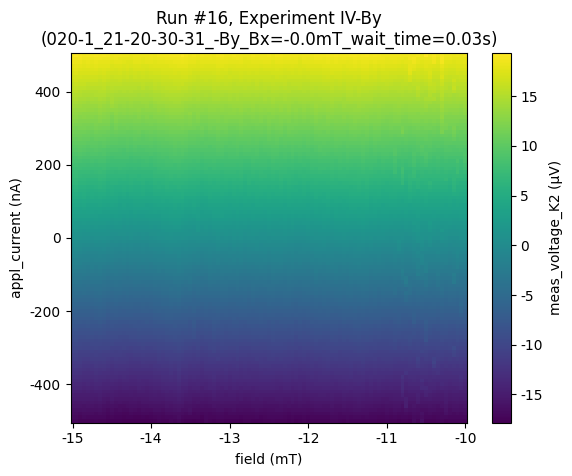

In [67]:
I_range=0.5e-6
wait_time = 30e-3
Bx = round(magnet_x.field() * 1e3, 2)
By = round(magnet_y.field() * 1e3, 2)

K2440.output(1)
appl_current(-I_range)
# direction = '-' if By > 0 else '+'

exp = qc.new_experiment('IV-By', sample_name=f'020-1_21-20-30-31_-By_{Bx=}mT_{wait_time=}s')

dataid = do2d(magnet_y.field, -10e-3, -15e-3, 101 , 0.5, appl_current, -I_range ,I_range, 101, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

There is (are) already experiment(s) with the name of IV-By and sample name of 020-1_21-20-30-31_-By_Bx=0.0mT_wait_time=0.03s in the database.


Starting experimental run with id: 27. 


first parameter: 100%|██████████| 351/351 [53:06<00:00,  9.08s/it]
Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #27, Experiment IV-By\n(020-1_21-20-30-31_-By_Bx=0.0mT_wait_time=0.03s)'}, xlabel='field (mT)', ylabel='appl_current (nA)'>],
 [<matplotlib.colorbar.Colorbar at 0x1f577b15850>])

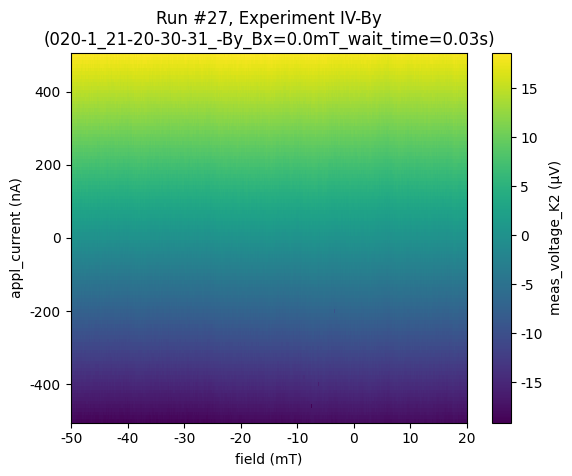

In [98]:
I_range=0.5e-6
wait_time = 30e-3
Bx = round(magnet_x.field() * 1e3, 2)
By = round(magnet_y.field() * 1e3, 2)

K2440.output(1)
appl_current(-I_range)
# direction = '-' if By > 0 else '+'

exp = qc.new_experiment('IV-By', sample_name=f'020-1_21-20-30-31_-By_{Bx=}mT_{wait_time=}s')

dataid = do2d(magnet_y.field, 20e-3, -50e-3, 351 , 0.5, appl_current, -I_range ,I_range, 101, wait_time , meas_voltage_K2)

appl_current(0)
K2440.output(0)

plot_by_id(dataid)

In [18]:
def plot_IV_and_dVdI(run_id=1):
    def R_fitting(run_id):
        import numpy as np
        from scipy.signal import find_peaks
        import pandas as pd
        dataset = qc.load_by_id(run_id)
        df = dataset.to_pandas_dataframe().reset_index()
        para_list = dataset.parameters.split(",")
        run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(dataset)
        df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
        current_0_index = df['appl_current'].abs().idxmin()
        
        dVdI_values = df['dV/dI'].values
        peaks1, _ = find_peaks(dVdI_values[dVdI_values > dVdI_values[current_0_index]])
        peaks0, _ = find_peaks(dVdI_values[dVdI_values < dVdI_values[current_0_index]])
        
        # Extract peak current and peak differential voltage values
        peak_current = [df['appl_current'].iloc[i] for i in peaks1]
        peak_R = [dVdI_values[i] for i in peaks1]

        # Sort the peaks based on their values
        sorted_peak_indices = np.argsort(peak_R)[::-1]  # Sort in descending order
        top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

        # Extract the top two peaks
        top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
        top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
        # Ensure peak0 is less than peak1
        peak0, peak1 = top_two_peak_current
        if peak1 < peak0:
            peak0, peak1 = peak1, peak0
            top_two_peak_current = peak0, peak1
        df_0 = df[df['appl_current'] < peak0]
        df_1 = df[df['appl_current'] > peak1]

        fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'], 1)
        fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'], 1)
        R_fit0 = fit_0[0]
        R_fit1 = fit_1[0]
        R_fit = (R_fit0 + R_fit1) / 2
        Ic = top_two_peak_current[1] - df['appl_current'].iloc[current_0_index]
        Ir = df['appl_current'].iloc[current_0_index] - top_two_peak_current[0]
        IcRn = Ic * R_fit
        return R_fit, R_fit0, R_fit1, top_two_peak_current, Ic, Ir, IcRn, current_0_index
    
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    para_list = dataset.parameters.split(",")
    R_fit, R_fit0, R_fit1, top_two_peak_current, Ic, Ir, IcRn, current_0_index = R_fitting(run_id)
    # Create traces
    # Trace1 IV
    trace1 = go.Scatter(x=df['appl_current'], y=df['meas_voltage_K2'], mode='lines', name='IV')
    # Trace2 dV/dI
    trace2 = go.Scatter(x=df['appl_current'], y=df['dV/dI'], mode='lines', name='dV/dI', yaxis='y2')
    # Trace3 Peak0
    trace3 = go.Scatter(x=[top_two_peak_current[0], top_two_peak_current[0]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak0', yaxis='y2')
    # Trace4 Peak1
    trace4 = go.Scatter(x=[top_two_peak_current[1], top_two_peak_current[1]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak1', yaxis='y2')
    # Trace5 I_0
    trace5 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], df['appl_current'].iloc[current_0_index]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='I_0', yaxis='y2')
    # Trace6 Ic
    trace6 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], top_two_peak_current[1]], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ic')
    # Trace7 I_r
    trace7 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], top_two_peak_current[0]], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ir')
    # Trace8 R_fit 
    trace8 = go.Scatter(x=[df['appl_current'].min(), df['appl_current'].max()], y=[R_fit * df['appl_current'].min(), R_fit * df['appl_current'].max()], mode='lines', line=dict(dash='dash'), name='R_fit') 
    
    # Create layout
    layout = go.Layout(
        title=f'<b>#{run_id} {exp_name} {sample_name}<br>R_fit={R_fit:.4f} Ω', 
        title_font=dict(size=25), title_x=0,
        xaxis=dict(title=para_list[0], tickfont=dict(size=16), title_font=dict(size=20)),
        yaxis=dict(title=f"{para_list[1]}", tickfont=dict(size=16), title_font=dict(size=20)),
        yaxis2=dict(title='dV/dI', tickfont=dict(size=16), title_font=dict(size=20), overlaying='y', side='right'),
        width=1000, height=1000, margin=dict(l=10, r=10, t=50, b=10),
        legend=dict(orientation="h",
                    x=0.5, y=1.03,
                    xanchor="center", yanchor="top",)
    )

    fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8], layout=layout)
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x=1,
                y=1,
                xref="paper",
                yref="paper",
                text=f"Ic = {Ic*1e6:.3f}µA, Ir = {Ir*1e6:.3f}µA ,IcRn = {IcRn*1e6:.3f} µV",
                showarrow=False,
                font=dict(
                    size=16,
                    color="#ffffff"
                ),
                align="right",
                bgcolor="#ff7f0e",
                opacity=0.8
            )
        ]
    )
    fig.show()
    print(f"Ic = {Ic*1e6} µA\n", 
          f"Ir = {Ir*1e6} µA\n",
          f"R_fit = {R_fit} Ω\n", 
          f"IcRn = {Ic*1e6*R_fit} µV\n",
          f"R_fit0 = {R_fit0} Ω\n", 
          f"R_fit1 = {R_fit1} Ω\n",
          )
    return 

def get_detaset_info(dataset):
    run_id = dataset.captured_run_id
    exp_name = dataset.exp_name
    sample_name = dataset.sample_name
    name = dataset.name
    description = dataset.description
    sample_junction = extract_sample_junction(sample_name)
    return run_id, exp_name, sample_name, sample_junction, name, description

def extract_sample_junction(sample_name):
    """Extracts the complete sample junction from the provided sample name.

    Args:
      sample_name: The name of the sample containing the junction information.

    Returns:
      The extracted sample junction, or None if not found.
    """

    delimiter = "_J"
    if delimiter in sample_name:
        # +3 to include "_J"
        return sample_name[:sample_name.find(delimiter) + 3]
    else:
        return None

In [35]:
get_R_from_IV(dataid)

1009.7675073756552